## Assignment - 4

### Team Members
1. Chaitanya jarugula
2. Karthikeya Reddy Kuchuru

In [ ]:
# Run this if you're in a Colab
!git clone https://github.com/greydanus/mnist1d

fatal: destination path 'mnist1d' already exists and is not an empty directory.


In [ ]:
import numpy as np
import torch
import random
import scipy.linalg as linalg
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from scipy.interpolate import interp1d
from tensorflow import keras
import torch.nn as nn
import torch.nn.functional as F


PROJECT_DIR = './'

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d
        
# Try attaching to GPU
DEVICE = str(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
print('Using:', DEVICE)

Using: cpu


In [ ]:
def get_templates():
    d0 = np.asarray([5,6,6.5,6.75,7,7,7,7,6.75,6.5,6,5])
    d1 = np.asarray([5,3,3,3.4,3.8,4.2,4.6,5,5.4,5.8,5,5])
    d2 = np.asarray([5,6,6.5,6.5,6,5.25,4.75,4,3.5,3.5,4,5])
    d3 = np.asarray([5,6,6.5,6.5,6,5,5,6,6.5,6.5,6,5])
    d4 = np.asarray([5,4.4,3.8,3.2,2.6,2.6,5,5,5,5,5,5])
    d5 = np.asarray([5,3,3,3,3,5,6,6.5,6.5,6,4.5,5])
    d6 = np.asarray([5,4,3.5,3.25,3,3,3,3,3.25,3.5,4,5])
    d7 = np.asarray([5,7,7,6.6,6.2,5.8,5.4,5,4.6,4.2,5,5])
    d8 = np.asarray([5,4,3.5,3.5,4,5,5,4,3.5,3.5,4,5])
    d9 = np.asarray([5,4,3.5,3.5,4,5,5,5,5,4.7,4.3,5])
    
    x = np.stack([d0,d1,d2,d3,d4,d5,d6,d7,d8,d9])
    x -= x.mean(1,keepdims=True) # whiten
    x /= x.std(1,keepdims=True)
    x -= x[:,:1]  # signal starts and ends at 0
    
    templates = {'x': x/6., 't': np.linspace(-5, 5, len(d0))/6.,
                 'y': np.asarray([0,1,2,3,4,5,6,7,8,9])}
    return templates

def plot_signals(xs, t, labels=None, args=None, ratio=2.6, do_transform=False, dark_mode=False, zoom=1):
    rows, cols = 1, 10
    fig = plt.figure(figsize=[cols*1.5,rows*1.5*ratio], dpi=60)
    for r in range(rows):
        for c in range(cols):
            ix = r*cols + c
            x, t = xs[ix], t
            ax = plt.subplot(rows,cols,ix+1)

            # plot the data
            if do_transform:
                assert args is not None, "Need an args object in order to do transforms"
                x, t = transform(x, t, args)  # optionally, transform the signal in some manner
            if dark_mode:
                plt.plot(x, t, 'wo', linewidth=6)
                ax.set_facecolor('k')
            else:
                plt.plot(x, t, 'k-', linewidth=2)
            if labels is not None:
                plt.title("label=" + str(labels[ix]), fontsize=22)

            plt.xlim(-zoom,zoom) ; plt.ylim(-zoom,zoom)
            plt.gca().invert_yaxis() ; plt.xticks([], []), plt.yticks([], [])
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.tight_layout() ; plt.show()
    return fig

In [ ]:
from IPython.display import Image
from IPython.core.display import HTML 
print("Examples from original MNIST dataset:")
URL = 'https://raw.githubusercontent.com/greydanus/mnist1d/master/static/mnist.png'
Image(url= URL,  width=800)

Examples from original MNIST dataset:


Templates for the MNIST-1D dataset:


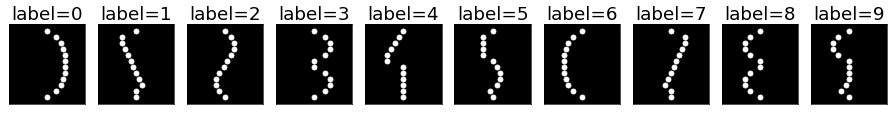

In [ ]:
templates = get_templates()
print("Templates for the MNIST-1D dataset:")
x = templates['x']
t = templates['t']
y = templates['y']
fig = plot_signals(x, t, labels=y, ratio=1.33, dark_mode=True)

# fig.savefig(PROJECT_DIR + 'static/mnist1d_black.png')

Templates for the MNIST-1D dataset:


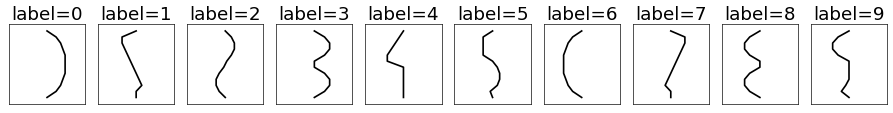

In [ ]:
templates = get_templates()
print("Templates for the MNIST-1D dataset:")
x = templates['x']
t = templates['t']
y = templates['y']
fig = plot_signals(x, t, labels=y, ratio=1.33, dark_mode=False)

# fig.savefig(PROJECT_DIR + 'static/mnist1d_white.png')

In [ ]:
# transformations of the templates which will make them harder to fit
def pad(x, padding):
    low, high = padding
    p = low + int(np.random.rand()*(high-low+1))
    return np.concatenate([x, np.zeros((p))])

def shear(x, scale=10):
    coeff = scale*(np.random.rand() - 0.5)
    return x - coeff*np.linspace(-0.5,.5,len(x))

def translate(x, max_translation):
    k = np.random.choice(max_translation)
    return np.concatenate([x[-k:], x[:-k]])

def corr_noise_like(x, scale):
    noise = scale * np.random.randn(*x.shape)
    return gaussian_filter(noise, 2)

def iid_noise_like(x, scale):
    noise = scale * np.random.randn(*x.shape)
    return noise

def interpolate(x, N):
    scale = np.linspace(0,1,len(x))
    new_scale = np.linspace(0,1,N)
    new_x = interp1d(scale, x, axis=0, kind='linear')(new_scale)
    return new_x

def transform(x, y, args, eps=1e-8):
    new_x = pad(x+eps, args.padding) # pad
    new_x = interpolate(new_x, args.template_len + args.padding[-1])  # dilate
    new_y = interpolate(y, args.template_len + args.padding[-1])
    new_x *= (1 + args.scale_coeff*(np.random.rand() - 0.5))  # scale
    new_x = translate(new_x, args.max_translation)  #translate
    
    # add noise
    mask = new_x != 0
    new_x = mask*new_x + (1-mask)*corr_noise_like(new_x, args.corr_noise_scale)
    new_x = new_x + iid_noise_like(new_x, args.iid_noise_scale)
    
    # shear and interpolate
    new_x = shear(new_x, args.shear_scale)
    new_x = interpolate(new_x, args.final_seq_length) # subsample
    new_y = interpolate(new_y, args.final_seq_length)
    return new_x, new_y

'''Modified the following get_data_set_args parameters:
1. num_samples = 500 (to create a subset of 500 samples of mnist-1d data set)
2. train_split = 1 (all 500 samples will be used in train_set and 0 samples will be used in test set)
'''
def get_dataset_args(as_dict=False):
    arg_dict = {'num_samples': 500,
            'train_split': 1,
            'template_len': 12,
            'padding': [36,60],
            'scale_coeff': .4, 
            'max_translation': 48,
            'corr_noise_scale': 0.25,
            'iid_noise_scale': 2e-2,
            'shear_scale': 0.75,
            'shuffle_seq': False,
            'final_seq_length': 40,
            'seed': 42}
    return arg_dict if as_dict else ObjectView(arg_dict)

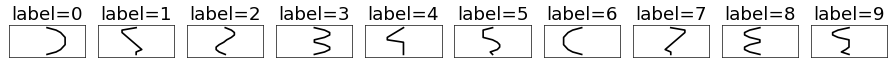

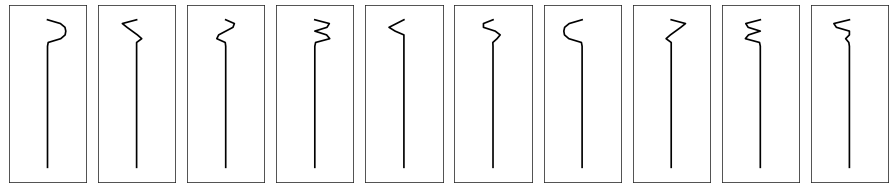

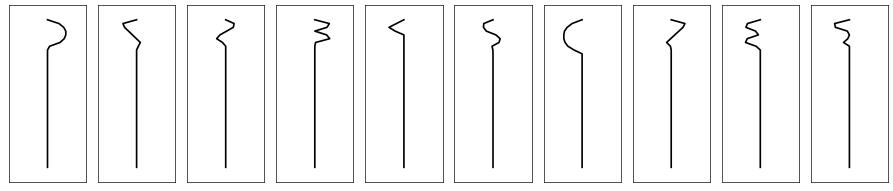

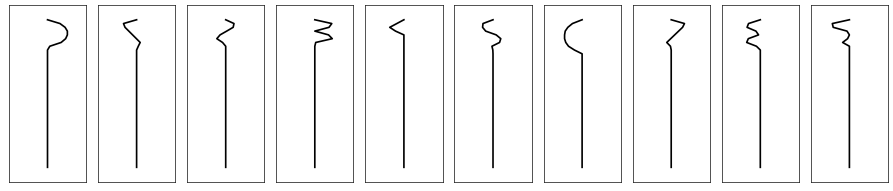

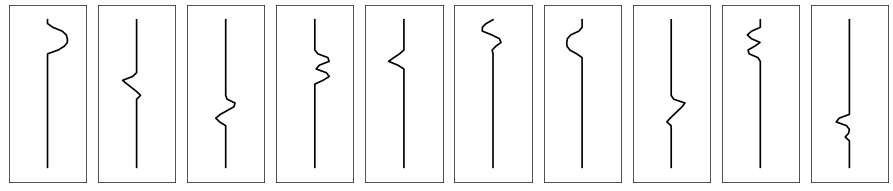

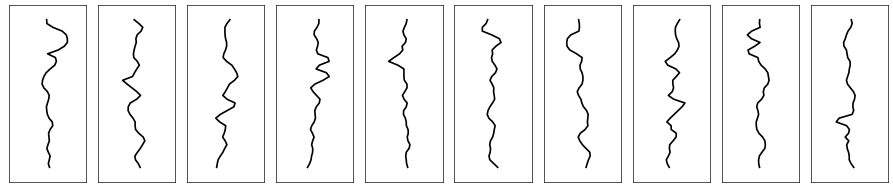

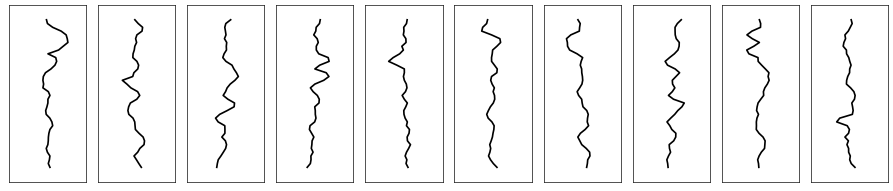

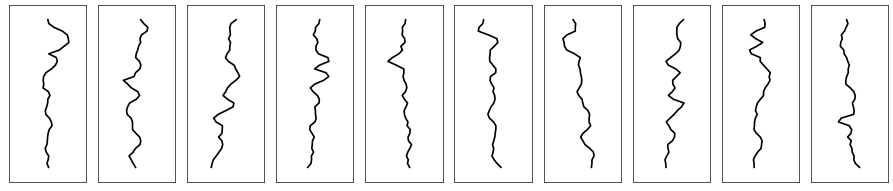

In [ ]:
def apply_ablations(arg_dict, n=7):
    ablations = [('shear_scale', 0),
                ('iid_noise_scale', 0),
                ('corr_noise_scale', 0),
                 ('max_translation', 1),
                 ('scale_coeff', 0),
                 ('padding', [arg_dict['padding'][-1], arg_dict['padding'][-1]]),
                 ('padding', [0, 0]),]
    num_ablations = min(n, len(ablations))
    for i in range(num_ablations):
        k, v = ablations[i]
        arg_dict[k] = v
    return arg_dict

templates = get_templates()
for i, n in enumerate(reversed(range(8))):
    np.random.seed(0)
    arg_dict = get_dataset_args(as_dict=True)
    arg_dict = apply_ablations(arg_dict, n=n)
    args = ObjectView(arg_dict)
    do_transform = args.padding[0] != 0
    fig = plot_signals(templates['x'], templates['t'], labels=None if do_transform else templates['y'],
                 args=args, ratio=2.2 if do_transform else 0.8,
                 do_transform=do_transform)
#     fig.savefig(PROJECT_DIR + 'static/transform_{}.png'.format(i))

In [ ]:
def make_dataset(args=None, template=None, ):
    templates = get_templates() if template is None else template
    args = get_dataset_args() if args is None else args
    np.random.seed(args.seed) # reproducibility
    
    xs, ys = [], []
    samples_per_class = args.num_samples // len(templates['y'])
    for label_ix in range(len(templates['y'])):
        for example_ix in range(samples_per_class):
            x = templates['x'][label_ix]
            t = templates['t']
            y = templates['y'][label_ix]
            x, new_t = transform(x, t, args) # new_t transformation is same each time
            xs.append(x) ; ys.append(y)
    
    batch_shuffle = np.random.permutation(len(ys)) # shuffle batch dimension
    xs = np.stack(xs)[batch_shuffle]
    ys = np.stack(ys)[batch_shuffle]
    
    if args.shuffle_seq: # maybe shuffle the spatial dimension
        seq_shuffle = np.random.permutation(args.final_seq_length)
        xs = xs[...,seq_shuffle]
    
    #new_t = new_t/xs.std()
    xs = (xs-xs.mean())/xs.std() # center the dataset & set standard deviation to 1

    # train / test split
    split_ix = int(len(ys)*args.train_split)
    dataset = {'x': xs[:split_ix], 'x_test': xs[split_ix:],
               'y': ys[:split_ix], 'y_test': ys[split_ix:],
               'templates': templates}
    return dataset

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [ ]:
args = get_dataset_args()
set_seed(args.seed)
args.shuffle_seq = False
data = make_dataset(args=args)  # make the dataset

set_seed(args.seed)
args.shuffle_seq = True
data_shuff = make_dataset(args=args)  # make the dataset, shuffling the spatial dimension
x_train, y_train = data['x'],data['y']
print("Examples in training set: {}".format(len(data['y'])))
print("Examples in test set: {}".format(len(data['y_test'])))
print("Length of each example: {}".format(data['x'].shape[-1]))
print("Number of classes: {}".format(len(data['templates']['y'])))

Examples in training set: 500
Examples in test set: 0
Length of each example: 40
Number of classes: 10


### Class for a single layer Fully connected neural network

In [ ]:
class FNN(nn.Module):
  def __init__(self, input_size, output_size, hidden_size=100):
    super(FNN, self).__init__()
    self.linear1 = nn.Linear(input_size, hidden_size)
    self.linear2 = nn.Linear(hidden_size, output_size)
    print("Initialized Fully connected Neural Network with {} parameters".format(self.count_params()))

  def count_params(self):
    return sum([p.view(-1).shape[0] for p in self.parameters()])

  def forward(self, x):
    h = self.linear1(x).relu()
    return self.linear2(h)

In [ ]:
import time, copy
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

def get_model_args(as_dict=False):
  arg_dict = {'input_size': 40,
          'output_size': 10,
          'hidden_size': 256,
          'learning_rate': 1e-2,
          'weight_decay': 0,
          'batch_size': 100,
          'total_steps': 8000,
          'print_every': 1000,
          'eval_every': 250,
          'checkpoint_every': 1000,
          'device': 'cpu',
          'seed': 42}
  return arg_dict if as_dict else ObjectView(arg_dict)


def accuracy(model, inputs, targets):
  preds = model(inputs).argmax(-1).cpu().numpy()
  targets = targets.cpu().numpy().astype(np.float32)
  return 100*sum(preds==targets)/len(targets)


def train_model(dataset, model, args):
  criterion = nn.MSELoss()
  optimizer = optim.SGD(model.parameters(), args.learning_rate, weight_decay=args.weight_decay)
  #x = F.normalize(torch.tensor(dataset['x']),p=2.0, dim=1, eps=1e-12, out=None)
  x = dataset['x']
  #x = x.type(torch.FloatTensor)
  x_train, x_test = torch.Tensor(x), torch.Tensor(dataset['x_test'])
  y_train, y_test = torch.LongTensor(dataset['y']), torch.LongTensor(dataset['y_test'])
  model = model.to(args.device)
  x_train, x_test, y_train, y_test = [v.to(args.device) for v in [x_train, x_test, y_train, y_test]]
  results = {'checkpoints':[], 'train_losses':[], 'test_losses':[],'train_acc':[],'test_acc':[]}
  t0 = time.time()
  train_loss = []
  #x_train = torch.Tensor(dataset['x'] / np.linalg.norm(dataset['x'], axis=1, keepdims=True))
  #test_x = data['x_test'] / np.linalg.norm(data['x_test'], axis=1, keepdims=True)
  for step in range(args.total_steps+1):
      bix = (step*args.batch_size)%len(x_train) # batch index
      x, y = x_train[bix:bix+args.batch_size], y_train[bix:bix+args.batch_size]
      #print(model(x).shape)
      y = F.one_hot(y,10) #create a one hot vector of the labels
      loss = criterion(model(x), y.float())  # convert them into float since MSELoss expects float value. 
      #print('Hi')
      results['train_losses'].append(loss.item())
      loss.backward() ; 
      optimizer.step() ; 
      optimizer.zero_grad()

      if args.eval_every > 0 and step % args.eval_every == 0: # evaluate the model
          results['train_acc'].append(accuracy(model, x_train, y_train))

      # if step > 0 and step % args.print_every == 0: # print out training progress
      #     t1 = time.time()
      #     print("step {}, dt {:.2f}s, train_loss {:.3e}, test_loss {:.3e}, train_acc {:.1f}, test_acc {:.1f}"
      #         .format(step, t1-t0, loss.item(), results['test_losses'][-1], \
      #                 results['train_acc'][-1], results['test_acc'][-1]))
      #     t0 = t1

      if step > 0 and step % args.print_every == 0: # print out training progress
          t1 = time.time()
          print("step {}, dt {:.2f}s, train_loss {:.3}, train_acc {:.1f}".format(step, t1-t0, loss.item(), results['train_acc'][-1]))
          #print("step {}, dt {:.2f}s, train_loss {:.3e}, test_loss {:.3e}, train_acc {:.1f}, test_acc {:.1f}".format(step, t1-t0, loss.item(), results['test_losses'][-1],results['train_acc'][-1], results['test_acc'][-1]))
          t0 = t1
          train_loss.append(loss.item())
      if args.checkpoint_every > 0 and step % args.checkpoint_every == 0: # save model checkpoints
          model.step = step
          results['checkpoints'].append( copy.deepcopy(model) )
  return results,train_loss

### Training single layer fully connected neural network with hidden_size = 10

Initialized Fully connected Neural Network with 520 parameters
step 1000, dt 0.49s, train_loss 0.0901, train_acc 19.2
step 2000, dt 0.46s, train_loss 0.0847, train_acc 24.8
step 3000, dt 0.47s, train_loss 0.0825, train_acc 28.0
step 4000, dt 0.45s, train_loss 0.0811, train_acc 30.0
step 5000, dt 0.47s, train_loss 0.08, train_acc 33.2
step 6000, dt 0.54s, train_loss 0.0789, train_acc 35.8
step 7000, dt 0.46s, train_loss 0.0779, train_acc 37.0
step 8000, dt 0.51s, train_loss 0.077, train_acc 38.8
step 9000, dt 0.47s, train_loss 0.0762, train_acc 39.8
step 10000, dt 0.45s, train_loss 0.0755, train_acc 38.8
step 11000, dt 0.45s, train_loss 0.0749, train_acc 40.2
step 12000, dt 0.46s, train_loss 0.0745, train_acc 41.0
step 13000, dt 0.45s, train_loss 0.074, train_acc 41.0
step 14000, dt 0.46s, train_loss 0.0736, train_acc 41.8
step 15000, dt 0.46s, train_loss 0.0733, train_acc 42.0
step 16000, dt 0.45s, train_loss 0.073, train_acc 42.0
step 17000, dt 0.45s, train_loss 0.0727, train_acc 42.8

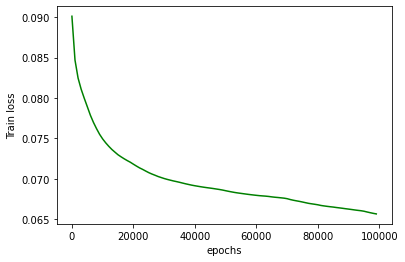

In [ ]:
args = get_model_args()
args.total_steps =  100000
args.device = DEVICE
set_seed(args.seed)
model = FNN(args.input_size,output_size=args.output_size,hidden_size = 10)
results_cnn,train_loss = train_model(data, model, args)
epochs = range(0,100000,1000)
plt.plot(epochs,train_loss,'g')
plt.xlabel('epochs')
plt.ylabel('Train loss')
print()

In [ ]:
# Extracting weights from the model
weights = model.linear1.weight.detach().numpy()

### Generating H(0) matrix for 10 hidden neuron neural network


In [ ]:
def indicator_func(x_i,x_j,w_r):
    if (np.dot(x_i.T,w_r) >= 0 and np.dot(x_j.T,w_r) >=0):
        return 1
    else:
        return 0
H_0=np.random.randn(500,500)
for i in range(500):
    for j in range(500):
        s=0
        for m in range(1,10):
            s+=indicator_func(x_train[i,:],x_train[j,:], weights[m,:])
        H_0[i][j]=((np.dot(x_train[i,:].T,x_train[j,:]))*s)/10
H_0

array([[20.77390014, -2.35322809,  0.92915833, ...,  9.52366645,
        -0.28738322, 11.16155107],
       [-2.35322809, 12.9998418 , -0.        , ..., -0.85813995,
         0.60187942, -1.46093871],
       [ 0.92915833, -0.        , 16.27466199, ...,  0.29169821,
        -0.        ,  1.13564378],
       ...,
       [ 9.52366645, -0.85813995,  0.29169821, ...,  8.9708895 ,
        -0.37737122,  8.461431  ],
       [-0.28738322,  0.60187942, -0.        , ..., -0.37737122,
         3.36365459, -1.6394872 ],
       [11.16155107, -1.46093871,  1.13564378, ...,  8.461431  ,
        -1.6394872 , 18.846309  ]])

In [ ]:
def predict(row, model):
    '''
    Input: data_points, model
    '''
    row = torch.Tensor([row])
    yhat = model(row)
    yhat = yhat.detach().numpy()
    return yhat
yhat = predict(x_train,model)
yhat = yhat.reshape(500,10)

In [ ]:
y_train_t = F.one_hot(torch.Tensor(y_train).to(torch.int64),10)
y_train_t = y_train_t.detach().numpy()
hashmap  = {}
criterion = nn.MSELoss()
for t in range(1000):
    z = y_train_t+np.dot(linalg.expm(-1*H_0*t),(yhat-y_train_t))
    hashmap[t]= np.amax(z)

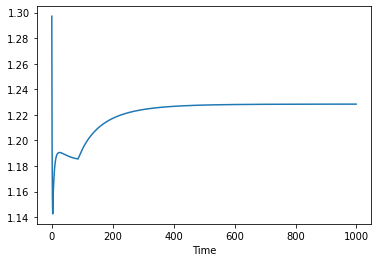

In [ ]:
plt.plot(list(hashmap.keys()),list(hashmap.values()))
plt.xlabel('Time')
plt.show()

### Training single layer fully connected neural network with hidden_size = 100

Initialized Fully connected Neural Network with 5110 parameters
step 1000, dt 1.83s, train_loss 0.0834, train_acc 31.2
step 2000, dt 1.80s, train_loss 0.0768, train_acc 39.2
step 3000, dt 1.74s, train_loss 0.0731, train_acc 45.4
step 4000, dt 2.25s, train_loss 0.0704, train_acc 51.0
step 5000, dt 2.20s, train_loss 0.0683, train_acc 54.6
step 6000, dt 1.77s, train_loss 0.0665, train_acc 57.0
step 7000, dt 2.34s, train_loss 0.0649, train_acc 59.6
step 8000, dt 2.24s, train_loss 0.0634, train_acc 62.4
step 9000, dt 2.06s, train_loss 0.062, train_acc 64.4
step 10000, dt 1.13s, train_loss 0.0608, train_acc 66.4
step 11000, dt 1.05s, train_loss 0.0595, train_acc 68.6
step 12000, dt 0.54s, train_loss 0.0584, train_acc 71.4
step 13000, dt 0.53s, train_loss 0.0573, train_acc 72.6
step 14000, dt 0.51s, train_loss 0.0562, train_acc 73.8
step 15000, dt 0.53s, train_loss 0.0552, train_acc 76.4
step 16000, dt 0.53s, train_loss 0.0542, train_acc 77.6
step 17000, dt 0.54s, train_loss 0.0533, train_acc

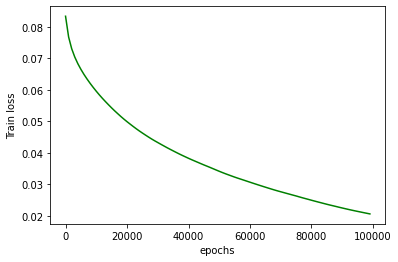

In [60]:
args = get_model_args()
args.total_steps =  100000
args.device = DEVICE
set_seed(args.seed)
model = FNN(args.input_size,output_size=args.output_size,hidden_size = 100)
results_cnn,train_loss = train_model(data, model, args)
epochs = range(0,100000,1000)
plt.plot(epochs,train_loss,'g')
plt.xlabel('epochs')
plt.ylabel('Train loss')
print()

In [61]:
# Extracting weights from the model
weights = model.linear1.weight.detach().numpy()

### Generating H(0) matrix for 100 hidden neuron neural network




In [62]:
def indicator_func(x_i,x_j,w_r):
    if (np.dot(x_i.T,w_r) >= 0 and np.dot(x_j.T,w_r) >= 0):
        return 1
    else:
        return 0
H_0=np.random.randn(500,500)
for i in range(500):
    for j in range(500):
        s = 0 
        for m in range(100):
            s += indicator_func(x_train[i,:],x_train[j,:], weights[m,:])
        H_0[i][j] = ((np.dot(x_train[i,:].T,x_train[j,:]))*s)/100
H_0

array([[14.19549843, -1.64725966,  1.672485  , ...,  4.920561  ,
        -0.71845805,  5.58077554],
       [-1.64725966, 25.9996836 , -4.55508661, ..., -0.91534928,
         2.28714178, -1.50963666],
       [ 1.672485  , -4.55508661, 22.24203806, ...,  0.52505677,
        -1.64919881,  2.27128756],
       ...,
       [ 4.920561  , -0.91534928,  0.52505677, ...,  7.47574125,
        -1.13211366,  5.640954  ],
       [-0.71845805,  2.28714178, -1.64919881, ..., -1.13211366,
        10.59551197, -2.21330771],
       [ 5.58077554, -1.50963666,  2.27128756, ...,  5.640954  ,
        -2.21330771, 12.92318332]])

In [63]:
def predict(row, model):
    '''
    Input: data_points, model
    '''
    row = torch.Tensor([row])
    yhat = model(row)
    yhat = yhat.detach().numpy()
    return yhat
yhat = predict(x_train,model)
yhat = yhat.reshape(500,10)

In [64]:
y_train_t = F.one_hot(torch.Tensor(y_train).to(torch.int64),10)
y_train_t = y_train_t.detach().numpy()
hashmap  = {}
for t in range(1000):
    z = y_train_t+np.dot(linalg.expm(-1*H_0*t),(yhat-y_train_t))
    hashmap[t]= np.amax(z)

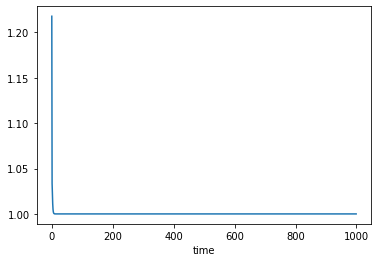

In [65]:
plt.plot(list(hashmap.keys()),list(hashmap.values()))
plt.ylabel('')
plt.xlabel('time')
plt.show()

### Training single layer fully connected neural network with hidden_size = 1000

Initialized Fully connected Neural Network with 51010 parameters
step 1000, dt 1.40s, train_loss 0.066, train_acc 58.0
step 2000, dt 1.37s, train_loss 0.0573, train_acc 73.8
step 3000, dt 1.37s, train_loss 0.0516, train_acc 81.2
step 4000, dt 1.35s, train_loss 0.0473, train_acc 86.4
step 5000, dt 1.36s, train_loss 0.0439, train_acc 90.2
step 6000, dt 1.37s, train_loss 0.041, train_acc 92.8
step 7000, dt 1.35s, train_loss 0.0384, train_acc 94.6
step 8000, dt 1.34s, train_loss 0.0361, train_acc 95.4
step 9000, dt 1.35s, train_loss 0.0341, train_acc 97.0
step 10000, dt 1.37s, train_loss 0.0321, train_acc 97.8
step 11000, dt 1.36s, train_loss 0.0304, train_acc 98.4
step 12000, dt 1.35s, train_loss 0.0287, train_acc 98.8
step 13000, dt 1.40s, train_loss 0.0272, train_acc 99.2
step 14000, dt 1.41s, train_loss 0.0257, train_acc 99.4
step 15000, dt 1.44s, train_loss 0.0243, train_acc 99.4
step 16000, dt 1.39s, train_loss 0.023, train_acc 99.6
step 17000, dt 1.35s, train_loss 0.0218, train_acc 

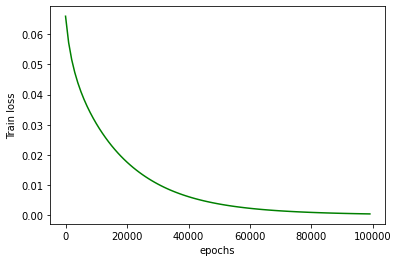

In [66]:
args = get_model_args()
args.total_steps =  100000
args.device = DEVICE
set_seed(args.seed)
model = FNN(args.input_size,output_size=args.output_size,hidden_size = 1000)
results_cnn,train_loss = train_model(data, model, args)
epochs = range(0,100000,1000)
plt.plot(epochs,train_loss,'g')
plt.xlabel('epochs')
plt.ylabel('Train loss')
print()

### Extracting weights from the model

In [67]:
# Extracting weights from the model
weights = model.linear1.weight.detach().numpy()

In [68]:
print(weights.shape)

(1000, 40)


### Generating H(0) matrix for 1000 hidden neuron neural network

In [69]:
def indicator_func(x_i,x_j,w_r):
    if (np.dot(x_i.T,w_r) >= 0 and np.dot(x_j.T,w_r) >=0):
        return 1
    else:
        return 0
H_0=np.random.randn(500,500)
for i in range(500):
    for j in range(500):
        s=0
        for m in range(1000):
            s+=indicator_func(x_train[i,:],x_train[j,:], weights[m,:])
        H_0[i][j]=((np.dot(x_train[i,:].T,x_train[j,:]))*s)/1000
H_0

array([[17.41545295, -1.74923288,  2.66668442, ...,  5.96816431,
        -0.68109823,  6.84575133],
       [-1.74923288, 22.31639509, -4.34485184, ..., -0.67793056,
         1.90795775, -1.20283954],
       [ 2.66668442, -4.34485184, 26.52769905, ...,  0.76133232,
        -1.71987876,  3.44100065],
       ...,
       [ 5.96816431, -0.67793056,  0.76133232, ...,  7.34117791,
        -0.84153782,  5.41531584],
       [-0.68109823,  1.90795775, -1.71987876, ..., -0.84153782,
         8.91368467, -1.82802822],
       [ 6.84575133, -1.20283954,  3.44100065, ...,  5.41531584,
        -1.82802822, 14.00011526]])

In [70]:
def predict(row, model):
    '''
    Input: data_points, model
    '''
    row = torch.Tensor([row])
    yhat = model(row)
    yhat = yhat.detach().numpy()
    return yhat
yhat = predict(x_train,model)
yhat = yhat.reshape(500,10)

In [71]:
y_train_t = F.one_hot(torch.Tensor(y_train).to(torch.int64),10)
y_train_t = y_train_t.detach().numpy()
hashmap  = {}
for t in range(1000):
    z = y_train_t+np.dot(linalg.expm(-1*H_0*t),(yhat-y_train_t))
    hashmap[t]= np.amax(z)
#print(z)

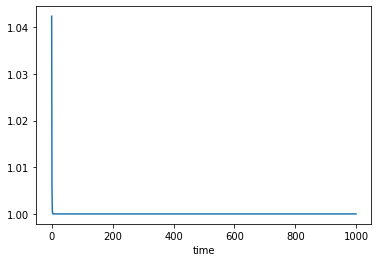

In [72]:
plt.plot(list(hashmap.keys()),list(hashmap.values()))
plt.xlabel('time')
plt.show()